### Air Quality Dataset Analysis


In this notebook, we have analyzed the **Historical Air Quality data set**. This data set is store in BigQuery public data set as `epa_historical_air_quality`. Eventually, we are going to learn the impact of air quality in spreading the respiratory diseases but here we are just exploring the dataset and pre-processing for the further analysis.

Importing the required libraries to run the analysis

In [1]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Authenticating with google cloud platform to access the project and the data set in BigQuery

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


These are some of the columns in our main table in the data set.

state_name	STRING	NULLABLE	

- `state_name` The name of the state where the monitoring site is located.
- `city_name` The name of the city where the monitoring site is located.
- `date_of_last_change` The date the last time any numeric values in this record were updated in the AQS data system.
- `latitude` The monitoring site’s angular distance north of the equator measured in decimal degrees.
- `longitude` The monitoring site’s angular distance east of the prime meridian measured in decimal degrees.
- `parameter_code` The AQS code corresponding to the parameter measured by the monitor.
- `poc` This is the “Parameter Occurrence Code” used to distinguish different instruments that measure the same parameter at the same site.
- `pollutant_standard` A description of the ambient air quality standard rules used to aggregate statistics.
- `metric_used` The base metric used in the calculation of the aggregate statistics presented in the remainder of the row. For example, if this is Daily Maximum, then the value in the Mean column is the mean of the daily maximums.
- `method_name` A short description of the processes, equipment, and protocols used in gathering and measuring the sample.
- `year` The year the annual summary data represents.

Let's look at the first few rows in the data set.

In [0]:
%%bigquery --project kbs-project-273101 quick_look_df
SELECT * FROM `bigquery-public-data.epa_historical_air_quality.air_quality_annual_summary` LIMIT 10

In [33]:
quick_look_df.head(3)

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,metric_used,method_name,year,units_of_measure,event_type,observation_count,observation_percent,completeness_indicator,valid_day_count,required_day_count,exceptional_data_count,null_data_count,primary_exceedance_count,secondary_exceedance_count,certification_indicator,num_obs_below_mdl,arithmetic_mean,arithmetic_standard_dev,first_max_value,first_max_datetime,second_max_value,second_max_datetime,third_max_value,third_max_datetime,fourth_max_value,fourth_max_datetime,first_max_non_overlapping_value,first_no_max_datetime,second_max_non_overlapping_value,second_no_max_datetime,ninety_nine_percentile,ninety_eight_percentile,ninety_five_percentile,ninety_percentile,seventy_five_percentile,fifty_percentile,ten_percentile,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
0,16,001,0021,68106,1,43.643055,-116.265718,WGS84,Sample Min Baro Pressure,24 HOUR,None,Observed Values,R & P Model 2025 PM2.5 Sequent - Barometric Se...,2003,Millimeters (mercury),No Events,61,100.0,Y,61,61,0,0,NaN,NaN,Certification not required,0,686.540984,4.440622,698.0,2003-12-17 00:00:00+00:00,696.0,2003-03-28 00:00:00+00:00,696.0,2003-10-24 00:00:00+00:00,694.0,2003-01-15 00:00:00+00:00,None,None,None,None,698.0,696.0,694.0,691.0,690.0,687.0,680.0,None,BRADLEY STREET,Idaho,Ada,Garden City,"Boise City, ID",2010-03-06
1,16,001,0021,68108,1,43.643055,-116.265718,WGS84,Average Ambient Pressure,24 HOUR,None,Observed Values,R & P Model 2025 PM2.5 Sequent - Barometric Se...,2002,Millimeters (mercury),No Events,23,100.0,N,23,23,0,0,NaN,NaN,Certification not required,0,689.695652,4.761921,700.0,2002-11-28 00:00:00+00:00,696.0,2002-12-04 00:00:00+00:00,694.0,2002-10-11 00:00:00+00:00,693.0,2002-11-22 00:00:00+00:00,None,None,None,None,700.0,700.0,696.0,694.0,692.0,690.0,685.0,None,BRADLEY STREET,Idaho,Ada,Garden City,"Boise City, ID",2010-03-05
2,16,001,0021,68102,1,43.643055,-116.265718,WGS84,Sample Volume,24 HOUR,None,Observed Values,R & P Model 2025 PM2.5 Sequent - Calculation,2003,Cubic meter,No Events,61,100.0,Y,61,61,0,0,NaN,NaN,Certification not required,0,23.978689,0.105063,24.0,2003-01-03 00:00:00+00:00,24.0,2003-01-09 00:00:00+00:00,24.0,2003-01-15 00:00:00+00:00,24.0,2003-01-21 00:00:00+00:00,None,None,None,None,24.0,24.0,24.0,24.0,24.0,24.0,24.0,None,BRADLEY STREET,Idaho,Ada,Garden City,"Boise City, ID",2010-03-06


In [0]:
%%bigquery --project kbs-project-273101 describe_df
SELECT observation_count, arithmetic_mean, arithmetic_standard_dev, fifty_percentile, seventy_five_percentile,
first_max_value, second_max_value, third_max_value, fourth_max_value, primary_exceedance_count,
num_obs_below_mdl, exceptional_data_count
FROM `bigquery-public-data.epa_historical_air_quality.air_quality_annual_summary`
WHERE state_name = "North Carolina" AND year = 2017

In [36]:
describe_df.describe()

,observation_count,arithmetic_mean,arithmetic_standard_dev,fifty_percentile,seventy_five_percentile,first_max_value,second_max_value,third_max_value,fourth_max_value,primary_exceedance_count,num_obs_below_mdl,exceptional_data_count
count,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,293.000000,1961.0,1961.000000
mean,2078.691994,18.910115,2.133132,18.892366,20.169897,29.201836,27.135935,26.078094,25.611586,0.194539,0.0,600.058644
std,8233.899209,107.541489,8.614083,107.836912,108.801051,115.844197,113.852781,112.895583,112.607307,2.594720,0.0,7062.227713
min,4.000000,-0.341382,0.000000,-0.400000,-0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,55.000000,0.000246,0.000929,0.000000,0.000000,0.006000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,61.000000,0.061667,0.105156,0.043000,0.058000,0.600000,0.400000,0.300000,0.200000,0.000000,0.0,0.000000
75%,335.000000,1.920000,1.590108,1.100000,2.400000,12.000000,9.500000,8.400000,7.200000,0.000000,0.0,0.000000
max,99564.000000,1439.836364,112.953312,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,44.000000,0.0,99564.000000


Environmental Protection Agency (EPA) uses Air Quality Index (AQI) to report daily air quality. They have defined a range of AQI to categorize and record the quality of the air which is more understandable.
This query sets threshold based on the range and finds out the number of days in each category for Charlotte, North Carolina in 2017.

In [0]:
%%bigquery --project kbs-project-273101 df
SELECT
  COUNT(date_local) AS NUM_OF_DAYS,
  CASE
    WHEN aqi < 51 THEN "Good (green)"
    WHEN aqi <101 THEN "Moderate (yellow)"
    WHEN aqi <151 THEN "Unhealthy for sensitive groups (orange)"
    WHEN aqi <201 THEN "Unhealthy (red)"
    WHEN aqi <301 THEN "Very unhealthy (purple)"
    WHEN aqi <501 THEN "Hazardous (maroon)"
    ELSE "unexpected data"
  END AS AQ_RATING
FROM
  `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
WHERE
  city_name='Charlotte'
  AND state_name = "North Carolina"
  AND sample_duration = "24 HOUR"
  AND poc = 1
  AND EXTRACT(YEAR FROM date_local) = 2017
GROUP BY
  AQ_RATING
ORDER BY
  NUM_OF_DAYS DESC

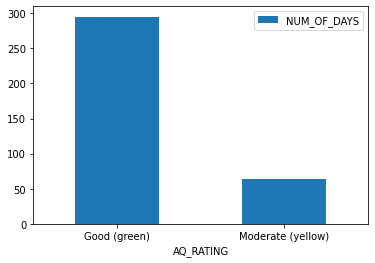

In [89]:
df.plot.bar(x='AQ_RATING', y="NUM_OF_DAYS", rot=0)

The query below retrieves the daily summary of air quality index of Miami, Florida in 2017 and plots in a scatterplot.

In [0]:
%%bigquery --project kbs-project-273101 daily_summary_df
SELECT
        extract(DAYOFYEAR from date_local) as day_of_year,
        aqi as AQI
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
    WHERE
      city_name = "Miami"
      AND state_name = "Florida"
      AND sample_duration = "24 HOUR"
      AND poc = 1
      AND EXTRACT(YEAR FROM date_local) = 2017
    ORDER BY day_of_year

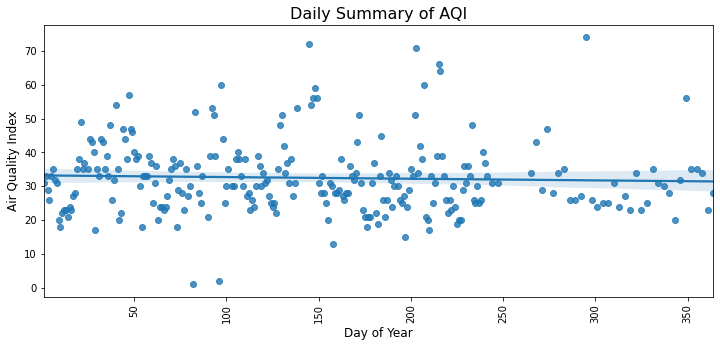

In [98]:
# daily_summary_df.plot(x='day_of_year', y='AQI', style='.');
plt.subplots(figsize=(12,5))
sns.regplot(data=daily_summary_df, x='day_of_year', y='AQI')
plt.ylabel('Air Quality Index', fontsize=12)
plt.xticks(rotation=90)
plt.xlabel('Day of Year', fontsize=12)
plt.title('Daily Summary of AQI', fontsize=16)
plt.show()

The query below retrieves the average AQI from the daily summary table. It shows a summary of daily air quality index for all the states in US. Generally, AQI ranges between 0-50 is considered as healthy.

In [0]:
%%bigquery --project kbs-project-273101 aqi_summary_df
SELECT
  EXTRACT(YEAR FROM date_local) as day_of_year,
  avg(aqi) as avg_aqi
FROM
  `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
WHERE
  poc = 1
GROUP BY day_of_year
ORDER BY day_of_year ASC

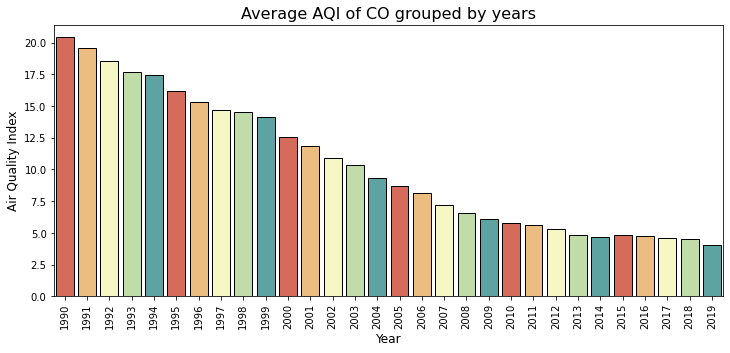

In [87]:
# # aqi_summary_df.plot.bar(x='day_of_year',y='avg_aqi')
plt.subplots(figsize=(12,5))
sns.barplot(x='day_of_year',y='avg_aqi', data=aqi_summary_df, palette=sns.color_palette('Spectral',5), edgecolor="#000")
plt.ylabel('Air Quality Index', fontsize=12)
plt.xticks(rotation=90)
plt.xlabel('Year', fontsize=12)
plt.title('Average AQI of CO grouped by years', fontsize=16)
plt.show()